# Transform and split DWPCs, assess performance

In [1]:
import itertools
import bz2

import pandas
import numpy
import sklearn.metrics
from scipy.special import logit

In [2]:
unperm_name = 'rephetio-v2.0'

In [3]:
feature_df = pandas.read_table('data/matrix/features.tsv.bz2')
feature_type_df = pandas.read_table('data/matrix/feature-type.tsv')

In [4]:
feature_df.head(2)

,hetnet,compound_id,disease_id,status,primary,disease_name,compound_name,prior_prob,CbG,CcSE,...,CuGuDpCpD,CuGuDpCtD,CuGuDpSpD,CuGuDrD,CuGuDrDrD,CuGuDtCpD,CuGuDtCtD,CuGuDuGaD,CuGuDuGdD,CuGuDuGuD
0,rephetio-v2.0_perm-5,DB00014,DOID:0060073,0,1,lymphatic system cancer,Goserelin,0.022675,2,249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,rephetio-v2.0,DB00091,DOID:0060073,0,1,lymphatic system cancer,Cyclosporine,0.047417,30,344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.028591,0.004754,0.0,0.0


In [5]:
feature_type_df.head(2)

,feature,feature_type,unperm_mean,unperm_sd
0,prior_prob,prior,0.040476,0.073232
1,CbG,degree,11.311000,12.444000


In [6]:
def transform_dwpcs(x, scaler):
    x = numpy.array(x)
    return numpy.arcsinh(x / scaler)

transformed_df = feature_df.copy()
dwpc_features = feature_type_df.query("feature_type == 'dwpc'").feature
degree_features = feature_type_df.query("feature_type == 'degree'").feature
feature_to_scaler = dict(zip(feature_type_df.feature, feature_type_df.unperm_mean))
for column in dwpc_features:
    transformed_df[column] = transform_dwpcs(transformed_df[column], feature_to_scaler[column])

In [7]:
column_names = list()
columns = list()
for metapath in dwpc_features:
    df = pandas.pivot_table(transformed_df, values=metapath, index=['compound_id', 'disease_id'], columns='hetnet')
    df = df[df['rephetio-v2.0'].notnull()]
    dwpc = df.iloc[:, 0]
    pdwpc = df.iloc[:, 1:].mean(axis='columns')
    rdwpc = dwpc - pdwpc
    for column in dwpc, pdwpc, rdwpc:
        columns.append(column)
    for feature_type in 'dwpc', 'pdwpc', 'rdwpc':
        column_names.append('{}_{}'.format(feature_type, metapath))

split_df = pandas.concat(columns, axis=1)
split_df.columns = column_names
split_df.reset_index(inplace=True)

In [8]:
split_df.head(2)

,compound_id,disease_id,dwpc_CbG<rG<rGaD,pdwpc_CbG<rG<rGaD,rdwpc_CbG<rG<rGaD,dwpc_CbG<rG<rGdD,pdwpc_CbG<rG<rGdD,rdwpc_CbG<rG<rGdD,dwpc_CbG<rG<rGuD,pdwpc_CbG<rG<rGuD,...,rdwpc_CuGuDtCtD,dwpc_CuGuDuGaD,pdwpc_CuGuDuGaD,rdwpc_CuGuDuGaD,dwpc_CuGuDuGdD,pdwpc_CuGuDuGdD,rdwpc_CuGuDuGdD,dwpc_CuGuDuGuD,pdwpc_CuGuDuGuD,rdwpc_CuGuDuGuD
0,DB00014,DOID:10283,0.0,0.043621,-0.043621,0.0,0.028787,-0.028787,0.0,0.022707,...,0.142122,0.615617,0.508843,0.106774,0.0,0.388299,-0.388299,0.105593,0.209833,-0.10424
1,DB00014,DOID:10534,0.0,0.058666,-0.058666,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.431882,0.342985,0.088897,0.0,0.000000,0.000000,0.000000,0.000000,0.00000


In [9]:
base_df = feature_df.query("hetnet == @unperm_name").copy()
base_df.insert(8, 'prior_logit', logit(base_df['prior_prob']))
for metaege in degree_features:
    base_df['degree_{}'.format(metaege)] = numpy.arcsinh(base_df[metaege])
base_df.drop(
    ['hetnet', 'primary', 'prior_prob'] + list(degree_features) + list(dwpc_features),
    axis='columns', inplace=True)
transformed_df = base_df.merge(split_df)
transformed_df.head(2)

,compound_id,disease_id,status,disease_name,compound_name,prior_logit,degree_CbG,degree_CcSE,degree_CdG,degree_CiPC,...,rdwpc_CuGuDtCtD,dwpc_CuGuDuGaD,pdwpc_CuGuDuGaD,rdwpc_CuGuDuGaD,dwpc_CuGuDuGdD,pdwpc_CuGuDuGdD,rdwpc_CuGuDuGdD,dwpc_CuGuDuGuD,pdwpc_CuGuDuGuD,rdwpc_CuGuDuGuD
0,DB00091,DOID:0060073,0,lymphatic system cancer,Cyclosporine,-3.000196,4.094622,6.533791,6.214612,1.443635,...,1.016867,1.273669,0.889808,0.383861,0.0,0.0,0.0,0.0,0.0,0.0
1,DB00206,DOID:0060073,0,lymphatic system cancer,Reserpine,-4.492476,2.776472,4.454482,5.337561,0.881374,...,-0.232211,0.495113,0.317494,0.177618,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
path = 'data/matrix/rephetio-v2.0/transformed-features.tsv.bz2'
with bz2.open(path, 'wt') as write_file:
    transformed_df.to_csv(write_file, sep='\t', index=False, float_format='%.5g')

### Compute performance

In [11]:
rows  = list()
for column in transformed_df.columns[transformed_df.columns.str.contains('dwpc')]:
    feature_type, metapath = column.split('_', 1)
    auroc = sklearn.metrics.roc_auc_score(transformed_df.status, transformed_df[column])
    rows.append([feature_type + '_auroc', metapath, auroc])
auroc_df = pandas.DataFrame(rows, columns=['feature_type', 'metapath', 'auroc'])
auroc_df = auroc_df.pivot_table(values='auroc', index='metapath', columns='feature_type').reset_index()
auroc_df.head(2)

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc
0,CbG<rG<rGaD,0.636046,0.613955,0.574447
1,CbG<rG<rGdD,0.580136,0.570848,0.536699


In [12]:
primary_auroc_df = pandas.read_table('data/feature-performance/primary-aurocs.tsv')
primary_auroc_df = primary_auroc_df.rename(columns={'feature': 'metapath', 'auroc_permuted': 'pdwpc_primary_auroc', 'pval_auroc': 'pval_delta_auroc'})
primary_auroc_df = primary_auroc_df[['metapath', 'nonzero', 'pdwpc_primary_auroc', 'delta_auroc', 'pval_delta_auroc']]
auroc_df = auroc_df.merge(primary_auroc_df)
auroc_df.head(2)

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc,nonzero,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
0,CbG<rG<rGaD,0.636046,0.613955,0.574447,0.84662,0.56577,0.070275,0.000020
1,CbG<rG<rGdD,0.580136,0.570848,0.536699,0.38146,0.54954,0.030600,0.000103


In [13]:
auroc_df.to_csv('data/feature-performance/auroc.tsv', sep='\t', index=False, float_format='%.5g')

In [14]:
#auroc_df.sort_values('rdwpc_auroc', ascending = False)
auroc_df[-auroc_df.metapath.str.contains('CtD')].sort_values('rdwpc_auroc', ascending = False).head()

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc,nonzero,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
27,CbGaD,0.712840,0.628067,0.669358,0.32238,0.56754,0.145300,6.114000e-07
178,CbGpPWpGaD,0.701548,0.650548,0.654061,0.97642,0.62547,0.076082,1.372500e-08
679,CrCbGaD,0.648075,0.589791,0.642535,0.41748,0.56589,0.082185,8.079100e-07
519,CiPCiCbGaD,0.657599,0.606607,0.639864,0.35576,0.56734,0.090258,1.038500e-05
752,CrCrCbGaD,0.620441,0.593827,0.639633,0.51709,0.58001,0.040433,4.739400e-05


## Visualization Sandbox

In [15]:
%matplotlib inline
import seaborn

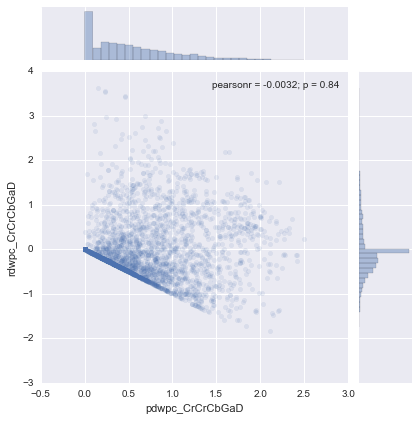

In [16]:
seaborn.jointplot(transformed_df['pdwpc_CrCrCbGaD'], transformed_df['rdwpc_CrCrCbGaD'], alpha = 0.1);

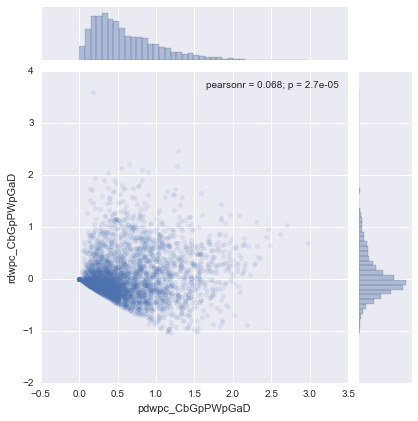

In [17]:
seaborn.jointplot(transformed_df['pdwpc_CbGpPWpGaD'], transformed_df['rdwpc_CbGpPWpGaD'], alpha = 0.1);

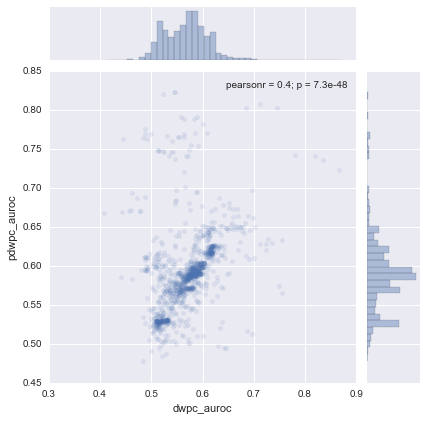

In [18]:
seaborn.jointplot(auroc_df['dwpc_auroc'], auroc_df['pdwpc_auroc'], alpha = 0.1);

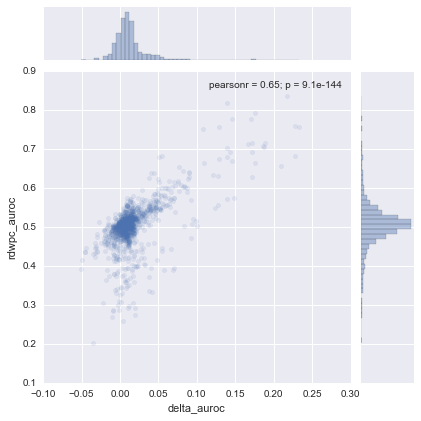

In [19]:
seaborn.jointplot(auroc_df['delta_auroc'], auroc_df['rdwpc_auroc'], alpha = 0.1);